In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import datetime
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [2]:
def simple_splitter(df, test_len=28):
    """splits off the tail of the dataframe for timeseries split
    returns 2 dataframes"""
    df_train = df[:-test_len]
    df_test = df[-test_len:]
    return df_train, df_test

In [3]:
def mape(y_true, y_pred):
    # mean absolute percent error
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100.

In [73]:
dfevents = pd.read_csv('../../data/ecommerce/events.csv')

In [59]:
# dfcat = pd.read_pickle('../../data/time_ecom/dfcat.pkl', compression='zip')
dfcatraw = pd.read_pickle('../../data/ecommerce/prod_with_cat.pkl', compression='zip')
# dfcatraw.info()

In [8]:
dfcandle = pd.read_csv('../../data/time_ecom/candle_scents.txt')
dfcandle.head(3)
# dfcandle

,scents
0,Beach Animals
1,Bunny Parmesan
2,Club Soda


In [54]:
dftree = pd.read_csv('../../data/ecommerce/category_tree.csv')
dftree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


In [11]:
print(dftree.shape)
dftree.head(3)

(1669, 2)


,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0


In [12]:
dftree['parentid'].value_counts()

250.0     31
1009.0    22
362.0     22
351.0     19
1259.0    18
          ..
813.0      1
47.0       1
1198.0     1
19.0       1
673.0      1
Name: parentid, Length: 362, dtype: int64

In [14]:
dftree[dftree['parentid'] == 250.].head(3)

,categoryid,parentid
34,7,250.0
35,1252,250.0
159,463,250.0


In [60]:
def format_df_cat_pickle(cat_prod):
    """make df_cat DataFrame for joining to dfevents
    load category DataFrame made in item_categories.py """
    cat_prod['value'] = cat_prod['value'].astype('int32')
    cat_prod.rename(columns={'value':'category'}, inplace=True)
    return cat_prod.copy()

In [61]:
dfcatformat = format_df_cat_pickle(dfcatraw)

In [62]:
def unix_time_convert(df):
    """convert from unix time format"""
    times=[]
    for i in df['timestamp']:
        times.append(datetime.datetime.fromtimestamp(i//1000.0))
    df['timestamp']=times
    return df.copy()

In [71]:
def join_categories(dfevents, dfcat, dftree):
    """ Input: raw dfevents, dfcat from format function, raw dftree
    join category column
    join parent column
    formatting of data into desired types
    """
    df = unix_time_convert(dfevents)
    df = df[df['event'] == 'transaction'].sort_values('timestamp')
    joined = df.join(dfcat.set_index('itemid'), on='itemid')
    joined['category'] = joined['category'].fillna(-1) # copy slice error??
    joined['category'] = joined['category'].astype('int32')
    # 23838 - 22547 = 1291 extra records from items with 2 categories
    joined = joined.drop_duplicates()
    # now join the parent column from dftree
    dftree.rename(columns={'parentid':'parent'}, inplace=True)
    parent = dftree.dropna()  #  from 1669 to 1644
    parent['parent'] = parent['parent'].astype('int32') # copy slice error??
    joined = joined.join(parent.set_index('categoryid'), on='category')
    joined['parent'] = joined['parent'].fillna(-2)
    joined['parent'] = joined['parent'].astype('int32')
    return joined.copy()

In [74]:
dff = join_categories(dfevents, dfcatformat, dftree)

/home/scorpio/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [77]:
print(dff.dropna().shape)
dff.head()

(23838, 7)


,timestamp,visitorid,event,itemid,transactionid,category,parent
1465072,2015-05-02 21:27:21,869008,transaction,40685,9765.0,1542,745
1463096,2015-05-02 21:35:01,345781,transaction,438400,1016.0,-1,-2
1464289,2015-05-02 22:01:47,586756,transaction,440917,10942.0,1415,14
1463462,2015-05-02 22:07:38,435495,transaction,175893,6173.0,1244,500
1464041,2015-05-02 22:31:14,266417,transaction,301359,12546.0,470,520


In [81]:
print(dff['category'].nunique(), dff['parent'].nunique())
dff['parent'].value_counts()[:10]

752 236


 561     918
 955     667
 105     565
 500     557
 1095    556
 805     553
 1426    494
-2       475
 1308    449
 1606    432
Name: parent, dtype: int64

In [84]:
dff.loc[dff['parent'] == 561, ['category']].nunique()
# 6 unique categories in parent 561

category    6
dtype: int64

In [92]:
dff.loc[dff['parent'] == 1426, ['category']].nunique()
# 9 unique categories in parent 1426

category    9
dtype: int64

In [98]:
def parent2day(df, select_int, par=True, fb=False):
    """takes DF 23838 with category and parent columns
    outputs daily purchases DF
    select_int is the desired category or parent to be selected
    par=True filters the parent column
    par=False filters the category column
    fb option toggles 'ds' & 'y' output format for FBprophet
    """
    # rename for working with FB prophet
    df.rename(columns={'event':'y'}, inplace=True)
    df.rename(columns={'timestamp':'ds'}, inplace=True)
    # filter parent
    if par:
        df = df[df['parent'] == select_int].sort_values('ds')
    # filter category
    else:
        df = df[df['category'] == select_int].sort_values('ds')
    # select columns for easier AGG
    df = df[['ds', 'y', 'category', 'parent']]
    # resample to daily frequency and count transactions
    dfday = df.resample('D', on="ds").count() 
    # make and join 139 df to pad missing head and tail
    dr = pd.date_range(start='2015-05-02', end='2015-09-17', freq='D')
    dfmake = pd.DataFrame(index=dr)
    dfmake = dfmake.join(dfday)
    # reset category/parent to be correct
    if par:
        dfmake['parent'] = select_int
    else:
        dfmake['category'] = select_int
    dfmake = dfmake.fillna(0)
    dfmake = dfmake.astype('int32')  #  the join made values floats
    # make ds, y format for FB
    if fb:  
        dfmake = dfmake[['y']].reset_index().rename(columns={'index': 'ds'})
    # remove partial days ( from 139 rows to 137 )
    dfmake = dfmake.iloc[1:-1]
    return dfmake.copy()

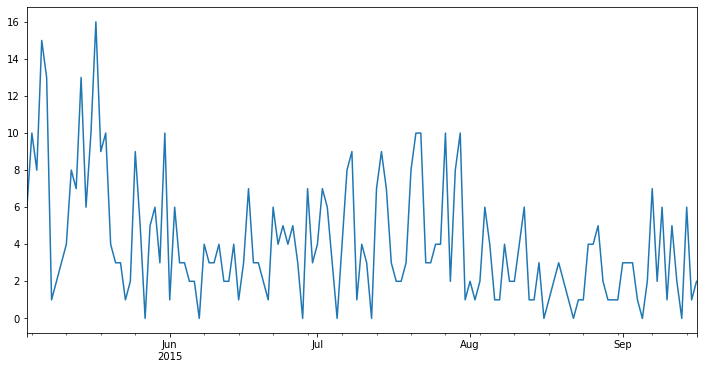

In [121]:
parent2day(dff, 500, par=True, fb=False)['y'].plot(figsize=(12,6))

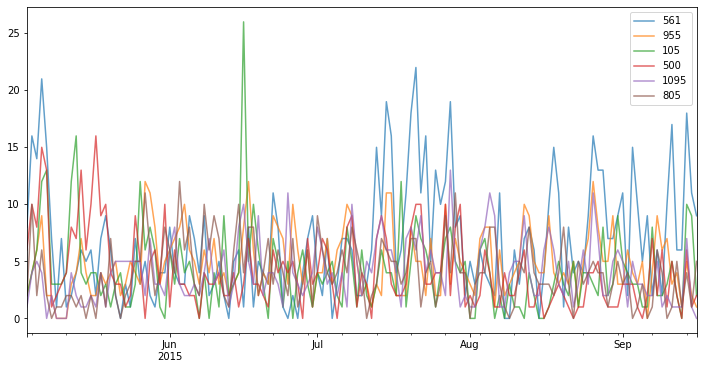

In [117]:
topparent = [561, 955, 105, 500, 1095, 805]
for par in topparent:
    parent2day(dff, par, par=True, fb=False)['y'].plot(figsize=(12,6), 
                                                legend=True, label=par, alpha=0.7)